In [1]:
import pyart, tempfile, boto3, pytz
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from datetime import datetime
from botocore.handlers import disable_signing


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
bucket = 'noaa-nexrad-level2'
s3 = boto3.resource('s3')
s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    
aws_radar = s3.Bucket(bucket)


In [4]:
#date = get_current_scan('2018/06/0/KLOT')


In [5]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x-pivot))

def find_my_key(radar_name):
    """
    Find the key in Amazon s3 corresponding to a particular radar site and 
    datetime
    
    Parameters
    ----------
    radar_name : str
        Four letter radar name
    desired_datetime : datetime
        The date time desired
    Returns
    -------
    my_key : string
        string matching the key for the radar file on AWS s3
    """
    
    bucket = "noaa-nexrad-level2"
    # Create a s3 "client"
    s3 = boto3.resource('s3')
    # Set it to unsigned
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    
    desired_datetime = datetime.utcnow() 
    target_string = datetime.strftime(desired_datetime, '%Y/%m/%d/'+radar_name)
    my_list_of_keys = [this_object.key for this_object in aws_radar.objects.filter(Prefix=target_string)]
    my_list_of_datetimes = []
    for obj in aws_radar.objects.filter(Prefix=target_string):
        try:
            my_list_of_datetimes.append(datetime.strptime(obj.key[20:35], '%Y%m%d_%H%M%S'))
        except ValueError:
            pass #usually a tar file left in the bucket
    
    my_nearest = nearest(my_list_of_datetimes, desired_datetime)
    my_key = my_list_of_keys[my_list_of_datetimes.index(my_nearest)]
    return my_key

In [17]:
my_key = find_my_key('KLOT')
print(my_key)

2018/06/05/KLOT/KLOT20180605_213138_V06


In [18]:
localfile = tempfile.NamedTemporaryFile()

aws_radar.download_file(my_key, localfile.name)

radar= pyart.io.read(localfile.name)
    

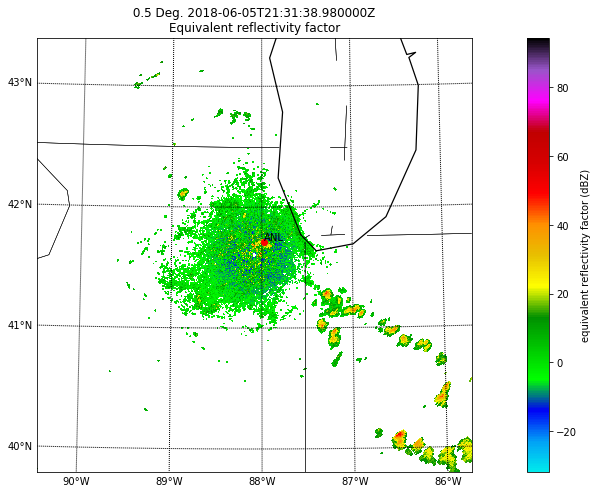

In [21]:
%matplotlib inline
fig = plt.figure(figsize=(20,8))
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('reflectivity', resolution='l',
                         sweep=0, fig=fig, width=400000, height=400000)
display.plot_point(-87.981810, 41.713969 , label_text='ANL', color = 'r')
